In [1]:
import pandas as pd
data_path = '../Data'

AF = f'{data_path}/FinalFeatures_AF.xlsx'
DIC = f'{data_path}/FinalFeatures_DIC.xlsx'

df1 = pd.read_excel(AF, engine='openpyxl')
df2 = pd.read_excel(DIC, engine='openpyxl')

In [2]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 98 non-null     object 
 1   Cell Area             98 non-null     int64  
 2   Cell Aspect Ratio     98 non-null     float64
 3   Cell Diameter         98 non-null     float64
 4   Nucleas Area          98 non-null     int64  
 5   Nucleas Aspect Ratio  98 non-null     float64
 6   Nulcleas Diameter     98 non-null     float64
 7   Cytoplasm Area        98 non-null     int64  
 8   NC Ratio              98 non-null     float64
 9   Cellular Perimeter    98 non-null     float64
 10  Nuclear Perimeter     98 non-null     float64
 11  Cytoplasm Perimeter   98 non-null     float64
 12  MeanGray              98 non-null     float64
 13  Median                98 non-null     int64  
 14  Variance              98 non-null     float64
 15  StandaredDeviation    98 

In [3]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Class                 105 non-null    object 
 1   Cell Area             99 non-null     float64
 2   Cell Aspect Ratio     99 non-null     float64
 3   Cell Diameter         99 non-null     float64
 4   Nucleas Area          100 non-null    float64
 5   Nucleas Aspect Ratio  100 non-null    float64
 6   Nulcleas Diameter     100 non-null    float64
 7   Cytoplasm Area        95 non-null     float64
 8   NC Ratio              95 non-null     float64
 9   Cellular Perimeter    99 non-null     float64
 10  Nuclear Perimeter     100 non-null    float64
 11  Cytoplasm Perimeter   95 non-null     float64
 12  MaxGray               105 non-null    int64  
 13  MinGray               105 non-null    int64  
 14  MeanGray              105 non-null    float64
 15  Median                1

In [4]:
print(len(df1.columns), len(df2.columns))

A = set(df1.columns).intersection(set(df2.columns))
B = [i for i in df2.columns if i not in A]
print(len([i for i in df1.columns if i not in A]), len(B))

25 35
0 10


In [5]:
B

['MaxGray',
 'MinGray',
 'DifferenceVariance',
 'DifferenceEntropy',
 'InverseDifference',
 'MaxProbability',
 'SumAverage',
 'SumEntropy',
 'SumSquaresVariance',
 'SumVariance']

In [6]:
Morphological_features_SIZE = ['Cell Area',
 'Nucleas Area',
 'Cytoplasm Area',
 'Cell Diameter',
 'Cell Diameter',
 'Nulcleas Diameter',
 'Nulcleas Diameter',
 'Cell Aspect Ratio',
 'Nucleas Aspect Ratio',
 'Cell Diameter',
 'Nulcleas Diameter',
 'NC Ratio']

Morphological_features_SHAPE = ['Cellular Perimeter',
 'Nuclear Perimeter',
 'Cytoplasm Perimeter']


haralick_texture_features = [
    'Contrast',              # Contrast (local changes in image)
    'Energy',                # Energy (uniformity of image)
    'Entropy',               # Entropy (randomness of intensity)
    'Homogenity',            # Homogeneity (similarity of pixels)
    'Correlation',           # Correlation (pixel neighborhood correlation)
    'Variance',              # Variance (uncertainty degree)
    'DifferenceEntropy',     # Difference Entropy (difference among pixel entropy)
    'SumVariance',           # Sum Variance (pixel uniformity)
    'SumAverage',            # Sum Average (average of gray level)
    # 'InverseDifferenceMoment', # Not explicitly in the dataset
    'ClusterProminence',     # Cluster Prominence (normalized gray-tone spatial dependence)
    # 'ClusterTendency',         # Not explicitly in the dataset
    'ClusterShade',          # Cluster Shade (cubic normalized gray-tone)
    # 'Inertia',                # Not explicitly in the dataset
    'SumSquaresVariance',    # Sum of Square Variance (squared deviation)
    # 'AngularSecondMoment',     # Not explicitly in the dataset
    # 'InformationMeasureCorrelationI', # Not explicitly in the dataset
    # 'InformationMeasureCorrelationII' # Not explicitly in the dataset
]



In [7]:
G = Morphological_features_SHAPE + Morphological_features_SIZE + haralick_texture_features
len(G)

27

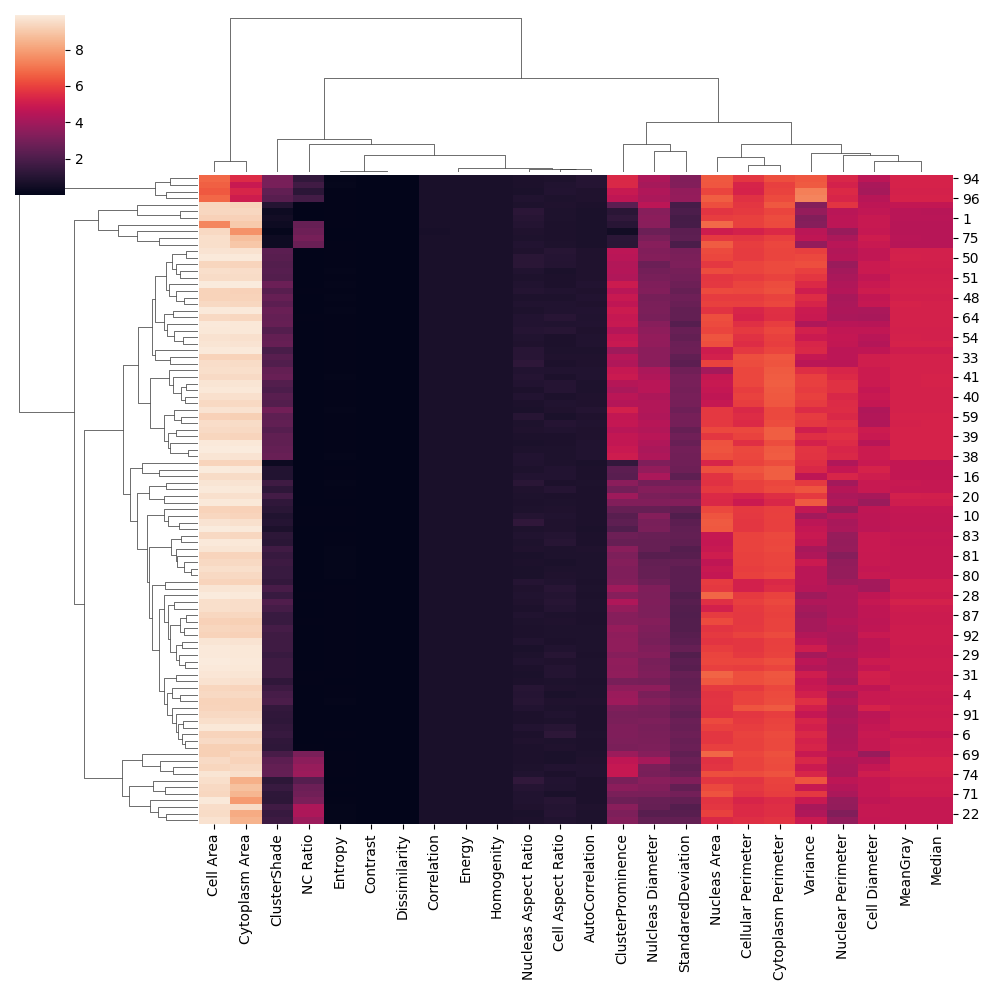

In [8]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Drop the 'Class' column as it's non-numerical
df1 = df1.drop(columns=['Class'])

# Check and replace infinite values
df1.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values (e.g., using mean imputation)
df1.fillna(df1.mean(), inplace=True)

# Ensure all values are finite and the data types are correct
df1_numeric = df1.apply(pd.to_numeric, errors='coerce')

df1_log = np.log1p(df1_numeric)  # log1p is used to handle zeros gracefully

sns.clustermap(df1_log, method='average', metric='euclidean', figsize=(10, 10))
plt.show()


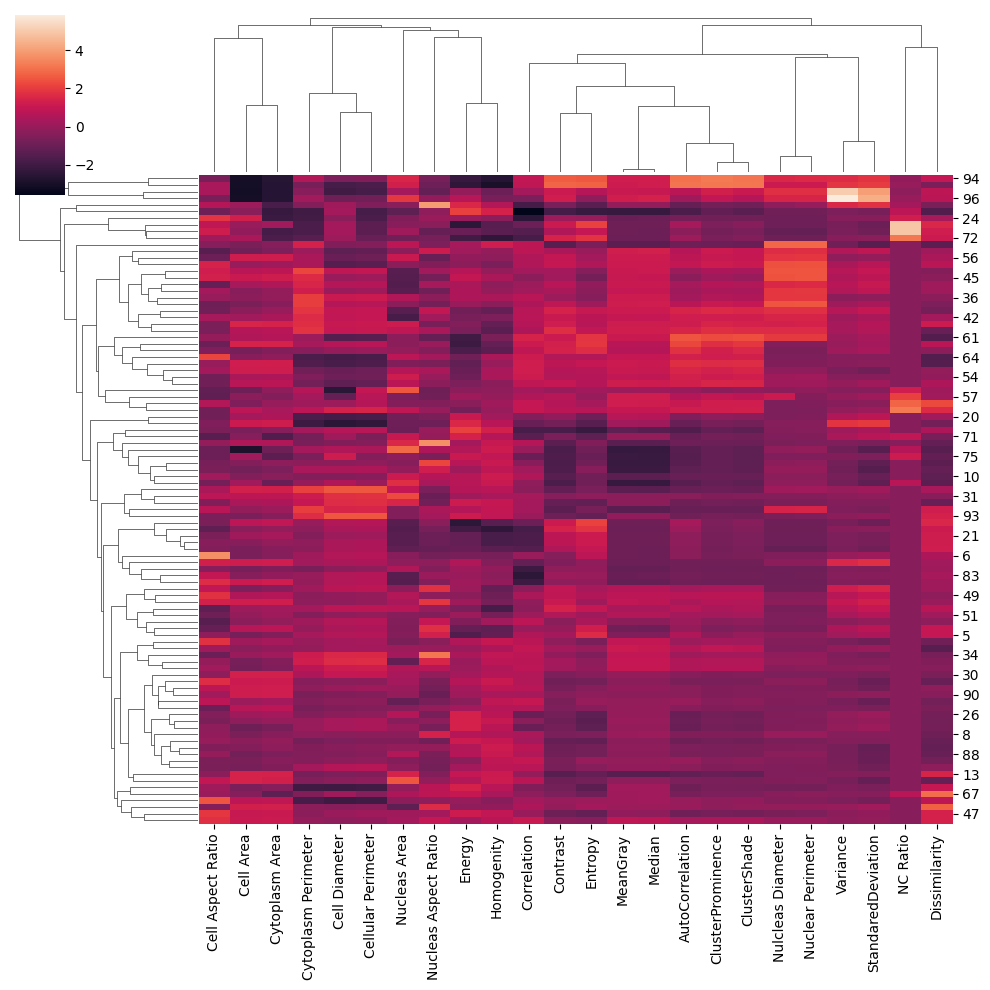

In [9]:
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
df1_scaled = pd.DataFrame(scaler.fit_transform(df1_numeric), columns=df1_numeric.columns)

sns.clustermap(df1_scaled, method='average', metric='euclidean', figsize=(10, 10))
plt.show()

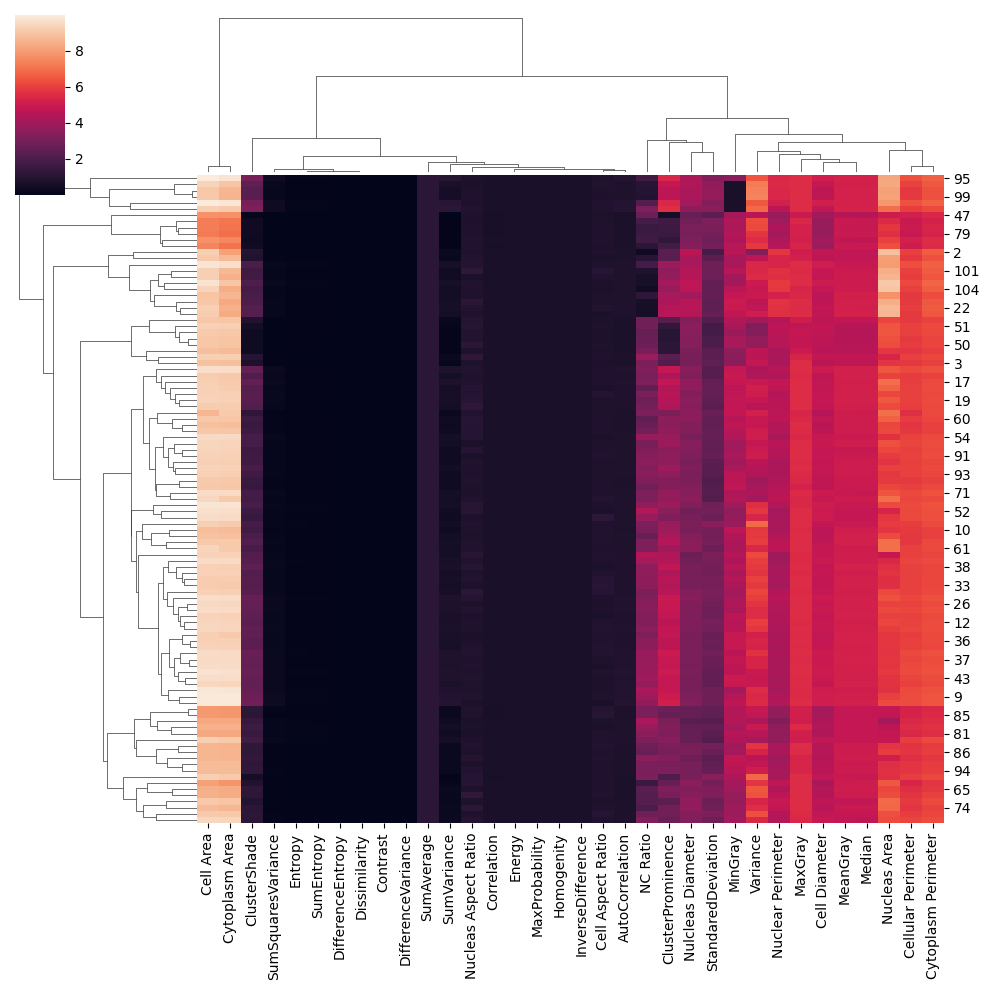

In [10]:

# Assuming df2 is already loaded

# Drop the 'Class' column as it's non-numerical
df2 = df2.drop(columns=['Class'])

# Check and replace infinite values
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle missing values (e.g., using mean imputation)
df2.fillna(df2.mean(), inplace=True)

# Ensure all values are finite and the data types are correct
df2_numeric = df2.apply(pd.to_numeric, errors='coerce')

df2_log = np.log1p(df2_numeric)  # log1p is used to handle zeros gracefully

sns.clustermap(df2_log, method='average', metric='euclidean', figsize=(10, 10))
plt.show()


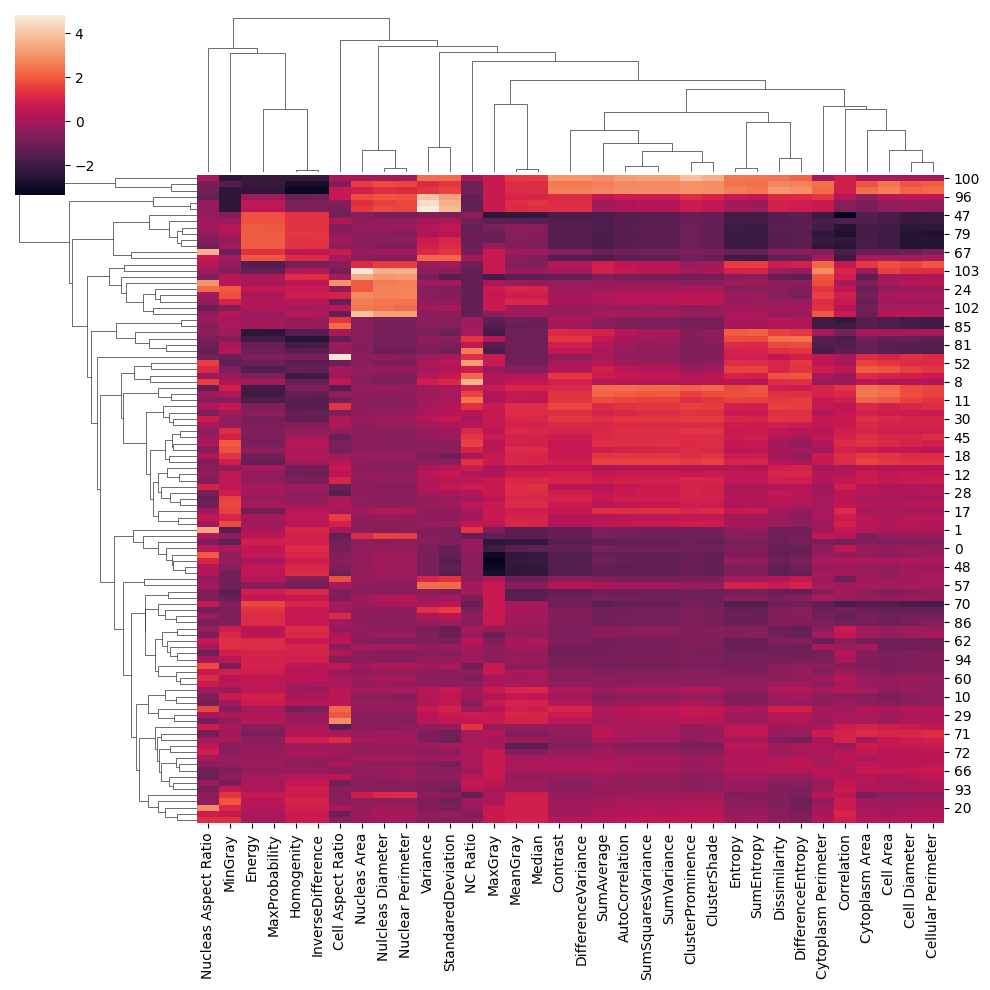

In [11]:
# Standardize the data
scaler = StandardScaler()
df2_scaled = pd.DataFrame(scaler.fit_transform(df2_numeric), columns=df2_numeric.columns)

sns.clustermap(df2_scaled, method='average', metric='euclidean', figsize=(10, 10))
plt.show()